In [1]:
import gymnasium as gym
from gymnasium import spaces

# PyTorch imports
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
device_ = torch.device(device)
print(device, " in use")
torch.autograd.set_detect_anomaly(True)

# Utility librarues
import base64, io
import random
import pickle
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from itertools import count

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

torch.cuda.get_device_name(0)

cuda  in use


/tmp/ipykernel_18970/3510240764.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'NVIDIA RTX A5500 Laptop GPU'

In [2]:
env = gym.make('InvertedDoublePendulum-v4')

obs_space = 11
action_space = 1

In [3]:
class Actor_net(nn.Module):
    def __init__(self):
        super(Actor_net, self).__init__()
        self.layer1 = nn.Linear(obs_space, 128)
        self.hidden = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_space) # action probabilities
        

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        action_prob = torch.tanh(self.out(x)) # -1 to 1
        return action_prob

In [4]:
class Critic_net(nn.Module):
    def __init__(self):
        super(Critic_net, self).__init__()
        self.layer1 = nn.Linear(obs_space + 1, 128)
        self.hidden = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        Q_val = self.out(x)
        return Q_val

In [5]:
Actor = Actor_net().to(device)
Critic = Critic_net().to(device)

Actor_lr = 0.0001
Actor_optim = optim.SGD(Actor.parameters(), lr = Actor_lr)
Qsa_lr = 0.0001
Critic_optim = optim.SGD(Critic.parameters(), lr = Qsa_lr)

## Load


In [6]:
PATH = "IP_Actor_QAC.pth"
Actor.load_state_dict(torch.load(PATH))

PATH = "IP_Critic_QAC.pth"
Critic.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [7]:
with open('IP_reward_epi_QAC.pkl', 'rb') as f:
    reward_epi = pickle.load(f)

with open('IP_avg_reward_QAC.pkl', 'rb') as f:
    avg_reward = pickle.load(f)

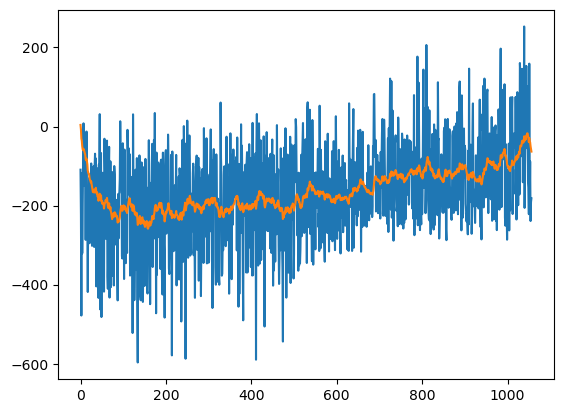

In [8]:
plt.plot(reward_epi, label = 'rew/epi')
plt.plot(avg_reward, label = 'avg_rew')

## Train

In [13]:
max_itr = 1000
gamma = 0.99
dist = Normal(0, 1)

In [14]:
dist.log_prob(torch.tensor(-1, dtype=float))

tensor(-1.4189, dtype=torch.float64)

In [15]:
def save_everythin():
    PATH = "IP_Actor_QAC.pth"
    torch.save(Actor.state_dict(), PATH)

    weights = Actor.state_dict()
    with open('IP_Actor_QAC.pkl', 'wb') as f:
        pickle.dump(weights, f)

    PATH = "IPr_Critic_QAC.pth"
    torch.save(Critic.state_dict(), PATH)

    weights = Critic.state_dict()
    with open('IP_Critic_QAC.pkl', 'wb') as f:
        pickle.dump(weights, f)

    with open('IP_reward_epi_QAC.pkl', 'wb') as f:
        pickle.dump(reward_epi, f)

    with open('IP_avg_reward_QAC.pkl', 'wb') as f:
        pickle.dump(avg_reward, f)

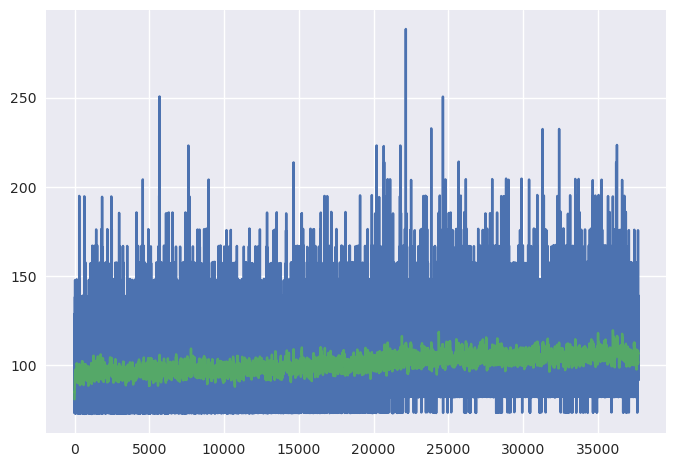

<Figure size 800x550 with 0 Axes>

In [16]:
reward_epi = []
avg_reward = []
running_reward = 80
for cnt in count():
    obs, info = env.reset()
    terminated, truncated = False, False
    ep_reward = 0

    for i in range(max_itr):

        a = Actor(torch.tensor(obs).float().to(device)) 
        a_log_prob = dist.log_prob(a)
        Qsa = Critic( torch.cat( (torch.tensor(obs).to(device), a.detach() )).to(device).float() )
        obs_next, reward, terminated, truncated, _ = env.step(a.detach().to("cpu").numpy())
        
        if terminated or truncated:
            expected = reward
        else:
            a_new = Actor(torch.tensor(obs_next).float().to(device))
            Qsa_next = Critic(torch.cat((torch.tensor(obs_next).to(device), a_new.detach() )).to(device).float() )#
            expected = reward + gamma*Qsa_next

        td_error = expected - Qsa

        Actor_loss = -a_log_prob*td_error.detach()
        Critic_loss = torch.square(expected - Qsa)

        Critic_optim.zero_grad()
        Critic_loss.backward()
        Critic_optim.step()

        Actor_optim.zero_grad()
        Actor_loss.backward()
        Actor_optim.step()

        obs = obs_next
        ep_reward += reward

        if truncated or terminated:
            reward_epi.append(ep_reward)
            break

    running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
    avg_reward.append(running_reward)
    
    if (cnt+1)% 10 == 0:
        plt.plot(reward_epi)
        plt.plot(avg_reward)
        plt.pause(0.1)
        

        display.display(plt.gcf())
        display.clear_output(wait=True)

    if (cnt+1)%100 == 0:
        save_everythin()
        

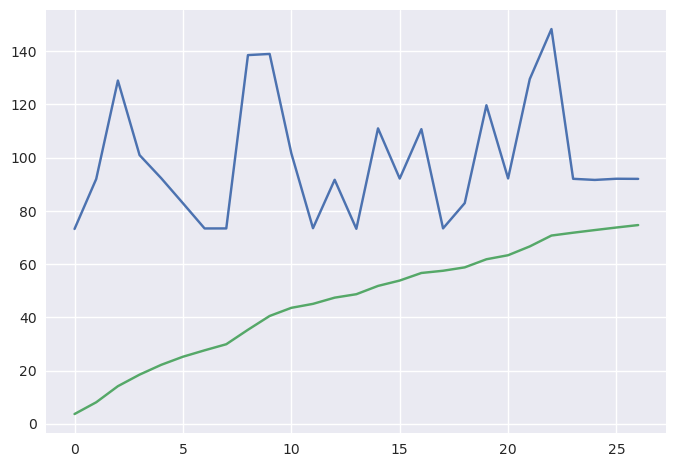

In [64]:
plt.plot(reward_epi, label = 'rew/epi')
plt.plot(avg_reward, label = 'avg_rew')

## Save 

In [11]:
save_everythin()

## Load

In [25]:
PATH = "LunarLander_Actor_QAC.pth"
Actor.load_state_dict(torch.load(PATH))

PATH = "LunarLander_Critic_QAC.pth"
Critic.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
with open('LunarLander_reward_epi_QAC.pkl', 'rb') as f:
    reward_epi = pickle.load(f)

with open('LunarLander_avg_reward_QAC.pkl', 'rb') as f:
    avg_reward = pickle.load(f)

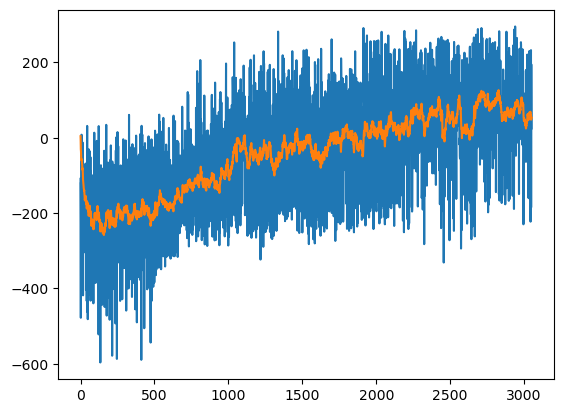

In [27]:
plt.plot(reward_epi, label = 'rew/epi')
plt.plot(avg_reward, label = 'avg_rew')